In [373]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, minmax_scale, scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [374]:
seed = 0

In [375]:
DATASETX = "./data/prep/HotelReservationsPreparedCleanX.csv"
DATASETY = "./data/prep/HotelReservationsY.csv"

In [376]:
df_x = pd.read_csv(DATASETX)
df_y = pd.read_csv(DATASETY)

In [377]:
df_x.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0


In [378]:
df_y.head()

,booking_status
0,1
1,1
2,1
3,0
4,1


In [379]:
df = pd.concat([df_x, df_y], axis=1)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6,1
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0,1
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0,1
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0,0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0,1


In [380]:
df = shuffle(df, random_state=seed)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
17405,0.0,-1.0,-0.714286,-0.882353,-1.0,1.0,0.0,-0.959368,0.272727,-0.200000,0.0,-1.0,-1.0,-1.0,-0.388889,0.2,1
25403,0.0,-1.0,-1.000000,-0.882353,-1.0,-1.0,0.0,-0.936795,0.636364,0.400000,0.0,-1.0,-1.0,-1.0,-0.407407,-1.0,0
13544,0.5,-1.0,-1.000000,-0.647059,-1.0,-1.0,1.0,-0.638826,0.272727,-0.866667,0.0,-1.0,-1.0,-1.0,-0.499000,-0.6,1
31848,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,1.0,-0.864560,0.636364,0.000000,0.0,-1.0,-1.0,-1.0,-0.560815,-0.6,1
9691,-0.5,-1.0,-0.428571,-0.411765,-1.0,-1.0,1.0,-0.977427,0.636364,-0.333333,1.0,-1.0,-1.0,-1.0,-0.592593,-1.0,1


In [381]:
# Dividimos el dataframe en train y test en una proporción de 80/20
X_train, X_test, y_train, y_test = train_test_split(df, df["booking_status"], test_size=0.2, random_state=seed)

# Dividimos el conjunto de prueba en test y validation en una proporción de 50/50
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [382]:
print("Train: ", X_train.shape)
print("Test: ", X_test.shape)
print("Validation: ", X_val.shape)

Train:  (29016, 17)
Test:  (3627, 17)
Validation:  (3627, 17)


In [383]:
INPUTS = X_train.shape[1]
OUTPUTS = 1
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (X_val.shape[0]/1))

In [384]:
n_epochs = 100
lr = 0.001
batch_size = 512
tasa_dropout = 0.2
n_neurons_per_hlayer = [50, 10]

In [385]:
model = keras.Sequential(name="DeepFeedforward")

In [386]:
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, activation="relu"))
  model.add(tf.keras.layers.Dropout(tasa_dropout))

model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "DeepFeedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 50)                900       
                                                                 
 dropout_39 (Dropout)        (None, 50)                0         
                                                                 
 dense_92 (Dense)            (None, 10)                510       
                                                                 
 dropout_40 (Dropout)        (None, 10)                0         
                                                                 
 dense_93 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1421 (5.55 KB)
Trainable params: 1421 (5.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [387]:
weights, biases = model.layers[0].get_weights()
weights.shape

(17, 50)

In [388]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["binary_accuracy"]
)


In [389]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(29016, 17)
(29016,)
(3627, 17)
(3627,)


In [390]:
start = time.perf_counter()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X_val, y_val))
print (time.perf_counter() - start)

Epoch 1/100


c:\dev\DL\venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 1s 5ms/step - loss: 0.5644 - binary_accuracy: 0.7044 - val_loss: 0.3562 - val_binary_accuracy: 0.9002
Epoch 2/100
46/57 [=======================>......] - ETA: 0s - loss: 0.2885 - binary_accuracy: 0.9163

c:\dev\DL\venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 0s 3ms/step - loss: 0.2657 - binary_accuracy: 0.9255 - val_loss: 0.0900 - val_binary_accuracy: 0.9989
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0988 - binary_accuracy: 0.9853 - val_loss: 0.0235 - val_binary_accuracy: 0.9997
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0444 - binary_accuracy: 0.9948 - val_loss: 0.0077 - val_binary_accuracy: 1.0000
Epoch 5/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0233 - binary_accuracy: 0.9974 - val_loss: 0.0033 - val_binary_accuracy: 1.0000
Epoch 6/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0151 - binary_accuracy: 0.9987 - val_loss: 0.0016 - val_binary_accuracy: 1.0000
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0096 - binary_accuracy: 0.9994 - val_loss: 8.6222e-04 - val_binary_accuracy: 1.0000
Epoch 8/100
57/57 [==============================] - 0s 3ms/step - loss: 0.007

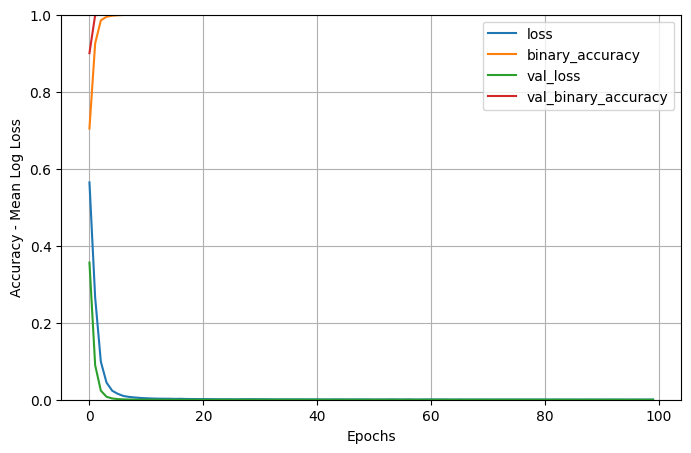

In [391]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig(f"./images/loss{n_neurons_per_hlayer}.png")
plt.show()

In [392]:
results[-1:]

,loss,binary_accuracy,val_loss,val_binary_accuracy
99,0.000386,0.999966,1.307024e-10,1.0


In [393]:
print(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}")
print(
    f"Accuracy for the development test set: {results.val_binary_accuracy.values[-1:][0]}"
)

Accuracy for the training set: 0.9999655485153198
Accuracy for the development test set: 1.0


In [394]:
v = open("./history/DeepFeedforward.txt", "a")
v.write(f"Epoque: {n_epochs}\n")
v.write(f"Learning Rate: {lr}\n")
v.write(f"Batch Size: {batch_size}\n")
v.write(f"Dropout: {tasa_dropout}\n")
v.write(f"Neurons per layer: {n_neurons_per_hlayer}\n")
v.write(f"Activation: relu\n")
v.write(f"Optimizer: Adam\n")
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.write(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}\n")
v.write(
    f"Accuracy for the development test set: {results.val_binary_accuracy.values[-1:][0]}\n"
)
v.write(f"Time: {time.perf_counter() - start}\n")
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.close()